# Transformation of columns for model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing

In [2]:
final_merge = pd.read_csv('../data/raw/final_merge.csv')
renta_media_disponible = pd.read_csv('../data/processed/renta_disponible.csv')

In [3]:
pd.set_option('display.max_columns',None)

In [4]:
final_merge.sample()

,NIA,curs_preinscripcio,convocatoria,curs_matricula,sexe,data_naixement,nacionalitat,pais,CP,poblacio,comarca,provincia,via_acces,nota_acces,ordre_assignacio,orientacio,aspectes_eleccio,any_qualificacio,convocatoria_qualificacio,treball_remunerat,estudis_pare,estudis_mare,ocupacio_pare,ocupacio_mare,codi_centre_secundaria,any_acabament_secundaria,tipus_centre_secundaria,tipus_lloc_secundaria,codi_lloc_secundaria,estudis_universitaris,any_acces_primera_vegada_universitat,titulacio_nivell_assolit,modalitat_acces,codi_grau,pla,any_academic,assignatura,codi_assignatura,grup,tipus,curs,semestre,exhaurides,superada,nota_numerica,nota_alfa
3773,1466322,2016,S,2016,H,1998-07-26,ESP,ESP,3540,Alicante,NaN,3.0,0,5.356,1,11,5,2016,S,3,6,6,2,2,NaN,2016.0,3.0,E,10,0,NaN,NaN,NaN,21026,879,2016,Mates,200138,401,B,1,1,3,S,4.5,SS


In [5]:
#To explore the data and understand the multiple variables we will use the df grouped by NIA's so we have 1 row x student
final_merge_students = final_merge.groupby('NIA').first().reset_index()

In [6]:
final_merge_students.shape #There is a total of 1299 students in the df to use

(1299, 46)

### Students information

#### Sex

In [7]:
#We will do onehotencoder. However, we migh have to work with the data imbalance between men and woman. 
final_merge_students['sexe'].value_counts()

sexe
H    1146
D     153
Name: count, dtype: int64

#### Age

In [8]:
# data_de_naixement can be transformed into the age of students when they are doing the assignatura (any_academic)
def get_age(df):
    df['data_naixement'] = pd.to_datetime(df['data_naixement'], format='%Y-%m-%d')
    df['any_academic'] = pd.to_datetime(df['any_academic'], format='%Y') + pd.offsets.DateOffset(months=8, days=0)
        #The last part adds the specified months and days to the date (in this case year-01-01).
        #We take 1st of september as the starting of the year
    df['edad'] = (df['any_academic'] - df['data_naixement']).dt.total_seconds() / (365.25 * 24 * 3600)
    df['edad'] = df['edad'].astype(int)
    return df

In [9]:
final_merge_students = get_age(final_merge_students)
final_merge = get_age(final_merge) #applying it also to the whole dataset

In [10]:
final_merge_students['edad'].value_counts()
#as expected, most students are between 17 and 20 years old their first year of uni.
#In future tirals is it possible to join 17 and 18 since this is the standard age to start uni vs people that hasn't started
#uni right the way after secondary school

edad
18    425
17    184
21    146
19    141
20    129
22     93
24     45
23     40
25     32
26     16
27      8
28      8
32      5
29      5
33      4
34      4
30      4
31      3
37      2
39      1
42      1
38      1
35      1
36      1
Name: count, dtype: int64

#### Nationality

In [11]:
final_merge_students['nacionalitat'].value_counts() 
#There is only 54 students (out of the 1299)  without spanish nationality so, for now, we won't consider nationality

nacionalitat
ESP    1245
CHN      10
AND       7
MAR       5
ITA       4
ROU       3
GEO       2
IRN       2
ECU       2
HND       2
COL       2
BRA       1
NPL       1
BOL       1
RUS       1
GNB       1
FRA       1
PRY       1
MEX       1
DEU       1
BEL       1
PHL       1
SAU       1
CAN       1
URY       1
LTU       1
Name: count, dtype: int64

#### Address

In [12]:
#Adding the column of renta_disponible_media because it will be our parameter for comparing if students residence affects
dict_ = {}

for index, row in renta_media_disponible.iterrows():
    CP = row["CP"]
    renta = row ["renta_disponible_media"]
    
    dict_[CP] = renta

final_merge["renta_media_disponible"] = final_merge["CP"].map(dict_)
final_merge_students["renta_media_disponible"] = final_merge_students["CP"].map(dict_)

#### Current work situacion

In [13]:
final_merge_students["treball_remunerat"].value_counts()

treball_remunerat
3    865
2    368
1     66
Name: count, dtype: int64

In [14]:
#Treball remunerat classifies students by:
    #1.Works less than 15 hours per week
    #2.Works 15 or more hours per week
    #3.Doesn't work
#We will create a rank ordered by more time to study to less time to study

new_dict_work_situation = {
    1 : 1,
    2 : 2,
    3 : 3}

final_merge_students["treball_remunerat"] = final_merge_students["treball_remunerat"].replace(new_dict_work_situation)
final_merge["treball_remunerat"] = final_merge["treball_remunerat"].replace(new_dict_work_situation)

### Previous education

#### Students with previous university experience

In [15]:
# We have the following variables that relate to previous university experience: 
    # 'estudis_universitaris': 0 (not in uni before) , 1 (previously university)
    # In case estudis_universitaris = 1 --> any_acces_primera_vegada_universitat', 'titulacio_nivell_assolit','modalitat_acces'

In [16]:
final_merge_students['estudis_universitaris'].sum() #273 students (out of the 1299) have previous uni experience

273

In [17]:
#On the other hand, we have the variable 'via_access' that categorizes students based on "where" are they coming from.
    #It takes the following values:
        # Via 0: PAU o assimilats
        # Via 2: Llicenciats, diplomats o assimilats
        # Via 4: CFGS o assimilats
        # Via 7: PAU amb carrera començada
        # Via 8: CFGS o assimilats amb carrera començada
        # Via 9: MG25 anys
        # Via 10: MG40 anys amb experiencia laboral
        # Via 11: MG45 anys

# Vies 7, 8 and 2 take into account this previous university student.

In [18]:
print('All students:')
print(f"{final_merge_students['via_acces'].value_counts()}")

All students:
via_acces
0    771
4    320
7    148
8     55
2      5
Name: count, dtype: int64


In [19]:
print('Students with previous university studies:')
print(f"{final_merge_students[final_merge_students['estudis_universitaris'] == 1]['via_acces'].value_counts()}")

Students with previous university studies:
via_acces
7    148
0     61
8     55
2      5
4      4
Name: count, dtype: int64


In [20]:
# We also observe that majority of students that have been in other universities drop out before the first year.
# For all this, we will not consider the variable of having been in other universities before. 

In [21]:
#Unifiying categories to later do the onehotencoder

new_dict_via_acces = {
    0 : 'PAU',
    4 : 'CFGS',
    7 : 'PAU',
    8 : 'CFGS',
    9 : 'altres_vies',
    2 : 'altres_vies'}

final_merge["via_acces"] = final_merge["via_acces"].replace(new_dict_via_acces)

In [22]:
final_merge["via_acces"].value_counts()

via_acces
PAU            8691
CFGS           2641
altres_vies      46
Name: count, dtype: int64

In [50]:
final_merge["via_acces_PAU"].value_counts()

via_acces_PAU
True     8623
False    1249
Name: count, dtype: int64

In [51]:
final_merge["via_acces_CFGS"].value_counts()

via_acces_CFGS
False    8669
True     1203
Name: count, dtype: int64

In [52]:
final_merge["via_acces_altres_vies"].value_counts()

via_acces_altres_vies
False    9826
True       46
Name: count, dtype: int64

#### Secondary school (Batxillerat) data

In [23]:
#We have the following information regarding secondary school data.
#This variables have some null values since not all students come from Batxillerat.

        # codi_centre_secundaria: 395 (Identification number for each school)
        # any_acabament_secundaria : 223
        # tipus_centre_secundaria: 223 ((1) Públic / (2) Privat / (3) Concertat)
        
    #Geographic variables: 
        # tipus_lloc_secundaria: 223 ((C) Catalunya (E) Espanya (A) Altres)
        # codi_lloc_secundaria: 223 (Catalunya la comarca, Espanya la CCAA, Estrangers països)

In [24]:
final_merge['tipus_centre_secundaria'].value_counts()

tipus_centre_secundaria
2.0    4664
1.0    3431
3.0    1777
Name: count, dtype: int64

In [25]:
#A different approach
#Unifiying categories to later do the onehotencoder, tipus_centre_secundaria

# new_dict_tipus_secundaria = {
#     1 : 'batx_public',
#     2 : 'batx_privat',
#     3 : 'batx_concertat',
# }

# final_merge["tipus_centre_secundaria"] = final_merge["tipus_centre_secundaria"].replace(new_dict_tipus_secundaria)
# final_merge["tipus_centre_secundaria"] = final_merge["tipus_centre_secundaria"].fillna('no_secondary_info')

In [26]:
#Establishing an order by university cost (from less (1 --> public) to more (3 --> private)
new_dict_tipus_secundaria = {
    1 : 1,
    2 : 3,
    3 : 2}

final_merge["tipus_centre_secundaria"] = final_merge["tipus_centre_secundaria"].replace(new_dict_tipus_secundaria)
final_merge["tipus_centre_secundaria"] = final_merge["tipus_centre_secundaria"].fillna('no_secondary_info')

#### Time from end of secondary to starting uni

In [27]:
# Does it affect on their grade how much time happens between students finalization of batx and their first semester at EUSS?
final_merge = final_merge.dropna(subset=['any_acabament_secundaria']) #we drop 218 out of 1299 students that do not have this information
final_merge['curs_matricula'] = final_merge['curs_matricula'].astype(int)
final_merge['any_acabament_secundaria'] = final_merge['any_acabament_secundaria'].astype(int)

In [28]:
final_merge['diferencia_anys'] = final_merge['curs_matricula'] - final_merge['any_acabament_secundaria']

### PAU exam & Matriculation information

In [29]:
final_merge_students['convocatoria_qualificacio'].value_counts()

convocatoria_qualificacio
J     1131
S      163
07       2
09       1
04       1
06       1
Name: count, dtype: int64

In [30]:
final_merge = final_merge.dropna(subset=['convocatoria_qualificacio'])

In [31]:
#convocatoria_qualificacio show students that take their access exam Juny and students in September, will it affect?

new_dict_convocatoria = {
    'J' : 'juny',
    'S' : 'setembre',
    '07' : 'altres_convocatories',
    '09' : 'altres_convocatories',
    '04' : 'altres_convocatories',
    '06' : 'altres_convocatories' }


final_merge['convocatoria_qualificacio'] = final_merge['convocatoria_qualificacio'].replace(new_dict_convocatoria)
final_merge_students['convocatoria_qualificacio'] = final_merge_students['convocatoria_qualificacio'].replace(new_dict_convocatoria)

In [32]:
final_merge_students['convocatoria_qualificacio'].value_counts() #There might be problems with imbalance

convocatoria_qualificacio
juny                    1131
setembre                 163
altres_convocatories       5
Name: count, dtype: int64

### Enrollment information

In [33]:
#'grup' gives us information about if students are part of the morning or the evening cohort (groups 701 , 801)

final_merge['grup'] = final_merge['grup'].astype(int)
grups = final_merge['grup']

new_dict_grup = {}

for grup in grups:
    if grup in (701, 801):
        new_dict_grup[grup] = 'tarda'
    else:
        new_dict_grup[grup] = 'mati'


final_merge["grup"] = final_merge["grup"].replace(new_dict_grup)
final_merge_students["grup"] = final_merge_students["grup"].replace(new_dict_grup)
final_merge_students["grup"].value_counts() #Data imbalance

grup
mati     1020
tarda     279
Name: count, dtype: int64

In [34]:
final_merge.columns

Index(['NIA', 'curs_preinscripcio', 'convocatoria', 'curs_matricula', 'sexe',
       'data_naixement', 'nacionalitat', 'pais', 'CP', 'poblacio', 'comarca',
       'provincia', 'via_acces', 'nota_acces', 'ordre_assignacio',
       'orientacio', 'aspectes_eleccio', 'any_qualificacio',
       'convocatoria_qualificacio', 'treball_remunerat', 'estudis_pare',
       'estudis_mare', 'ocupacio_pare', 'ocupacio_mare',
       'codi_centre_secundaria', 'any_acabament_secundaria',
       'tipus_centre_secundaria', 'tipus_lloc_secundaria',
       'codi_lloc_secundaria', 'estudis_universitaris',
       'any_acces_primera_vegada_universitat', 'titulacio_nivell_assolit',
       'modalitat_acces', 'codi_grau', 'pla', 'any_academic', 'assignatura',
       'codi_assignatura', 'grup', 'tipus', 'curs', 'semestre', 'exhaurides',
       'superada', 'nota_numerica', 'nota_alfa', 'edad',
       'renta_media_disponible', 'diferencia_anys'],
      dtype='object')

In [35]:
#To work with the model we need only a few of this columns

columns_to_drop = ['curs_preinscripcio','convocatoria','curs_matricula', 'data_naixement',
                   'nacionalitat','pais', 'CP', 'poblacio', 'comarca','provincia',
                   'any_qualificacio','codi_centre_secundaria','any_acabament_secundaria','tipus_lloc_secundaria', 'codi_lloc_secundaria',
                   'estudis_universitaris','any_acces_primera_vegada_universitat', 'titulacio_nivell_assolit','modalitat_acces',
                    'codi_grau', 'pla','any_academic',
                   'codi_assignatura','tipus', 'curs', 'semestre', 'exhaurides','superada']

final_merge = final_merge.drop(columns = columns_to_drop)

----------------------------

### Encoding to try the model

In [36]:
def transform_features(df):
    
    #sexe
    onehotencoder = preprocessing.OneHotEncoder()
    df[["H", "D"]] = onehotencoder.fit_transform(df["sexe"].values.reshape(-1, 1)).toarray()
    df.drop(columns="sexe", inplace=True)

    
    #via_acces
    df = pd.get_dummies(df, columns=["via_acces"], prefix=["via_acces"])
    
#     #tipus_centre_secundaria
#     onehotencoder = preprocessing.OneHotEncoder()
#     df[["batx_public", "batx_privat", "batx_concertat"]] = onehotencoder.fit_transform(df["tipus_centre_secundaria"].values.reshape(-1, 1)).toarray()
#     df.drop(columns="tipus_centre_secundaria", inplace=True)
    
    #convocatoria
    onehotencoder = preprocessing.OneHotEncoder()
    df[["juny", "setembre","altres_convocatories"]] = onehotencoder.fit_transform(df['convocatoria_qualificacio'].values.reshape(-1, 1)).toarray()
    df.drop(columns="convocatoria_qualificacio", inplace=True)
    
    #grup
    onehotencoder = preprocessing.OneHotEncoder()
    df[["mati", "tarda"]] = onehotencoder.fit_transform(df["grup"].values.reshape(-1, 1)).toarray()
    df.drop(columns="grup", inplace=True)
    
    return df

In [37]:
final_merge = transform_features(final_merge)

In [38]:
final_merge.columns

Index(['NIA', 'nota_acces', 'ordre_assignacio', 'orientacio',
       'aspectes_eleccio', 'treball_remunerat', 'estudis_pare', 'estudis_mare',
       'ocupacio_pare', 'ocupacio_mare', 'tipus_centre_secundaria',
       'assignatura', 'nota_numerica', 'nota_alfa', 'edad',
       'renta_media_disponible', 'diferencia_anys', 'H', 'D', 'via_acces_CFGS',
       'via_acces_PAU', 'via_acces_altres_vies', 'juny', 'setembre',
       'altres_convocatories', 'mati', 'tarda'],
      dtype='object')

In [39]:
final_merge.shape[1] #We have 27 variables for our model, will need to check this number every trial and error. 

27

In [43]:
order = ['NIA', 'nota_acces', 'ordre_assignacio', 'orientacio',
       'aspectes_eleccio', 'estudis_pare', 'estudis_mare',
       'ocupacio_pare', 'ocupacio_mare','edad','diferencia_anys', 'renta_media_disponible', 'tipus_centre_secundaria',
         'H', 'D','via_acces_PAU', 'via_acces_CFGS','via_acces_altres_vies' , 'juny', 'setembre', 'altres_convocatories', 'mati','tarda', 'treball_remunerat',
         'assignatura','nota_numerica', 'nota_alfa']
final_merge = final_merge[order]

In [44]:
final_merge.to_csv('../data/processed/final_merge_model.csv',index=False)

### Features correlation

In [45]:
#We will drop the NIA and will use only numeric variables to check the correlation matrix

In [47]:
numeric_variables = final_merge[['nota_acces', 'ordre_assignacio', 'orientacio',
       'aspectes_eleccio', 'estudis_pare', 'estudis_mare',
       'ocupacio_pare', 'ocupacio_mare','edad','diferencia_anys', 'renta_media_disponible', 'tipus_centre_secundaria',
         'H', 'D','via_acces_PAU', 'via_acces_CFGS','via_acces_altres_vies' , 'juny', 'setembre', 'altres_convocatories', 'mati','tarda', 'treball_remunerat',
         'nota_numerica']]

In [ ]:
correlation = check.groupby('NIA').agg('nota_numerica')
correlation

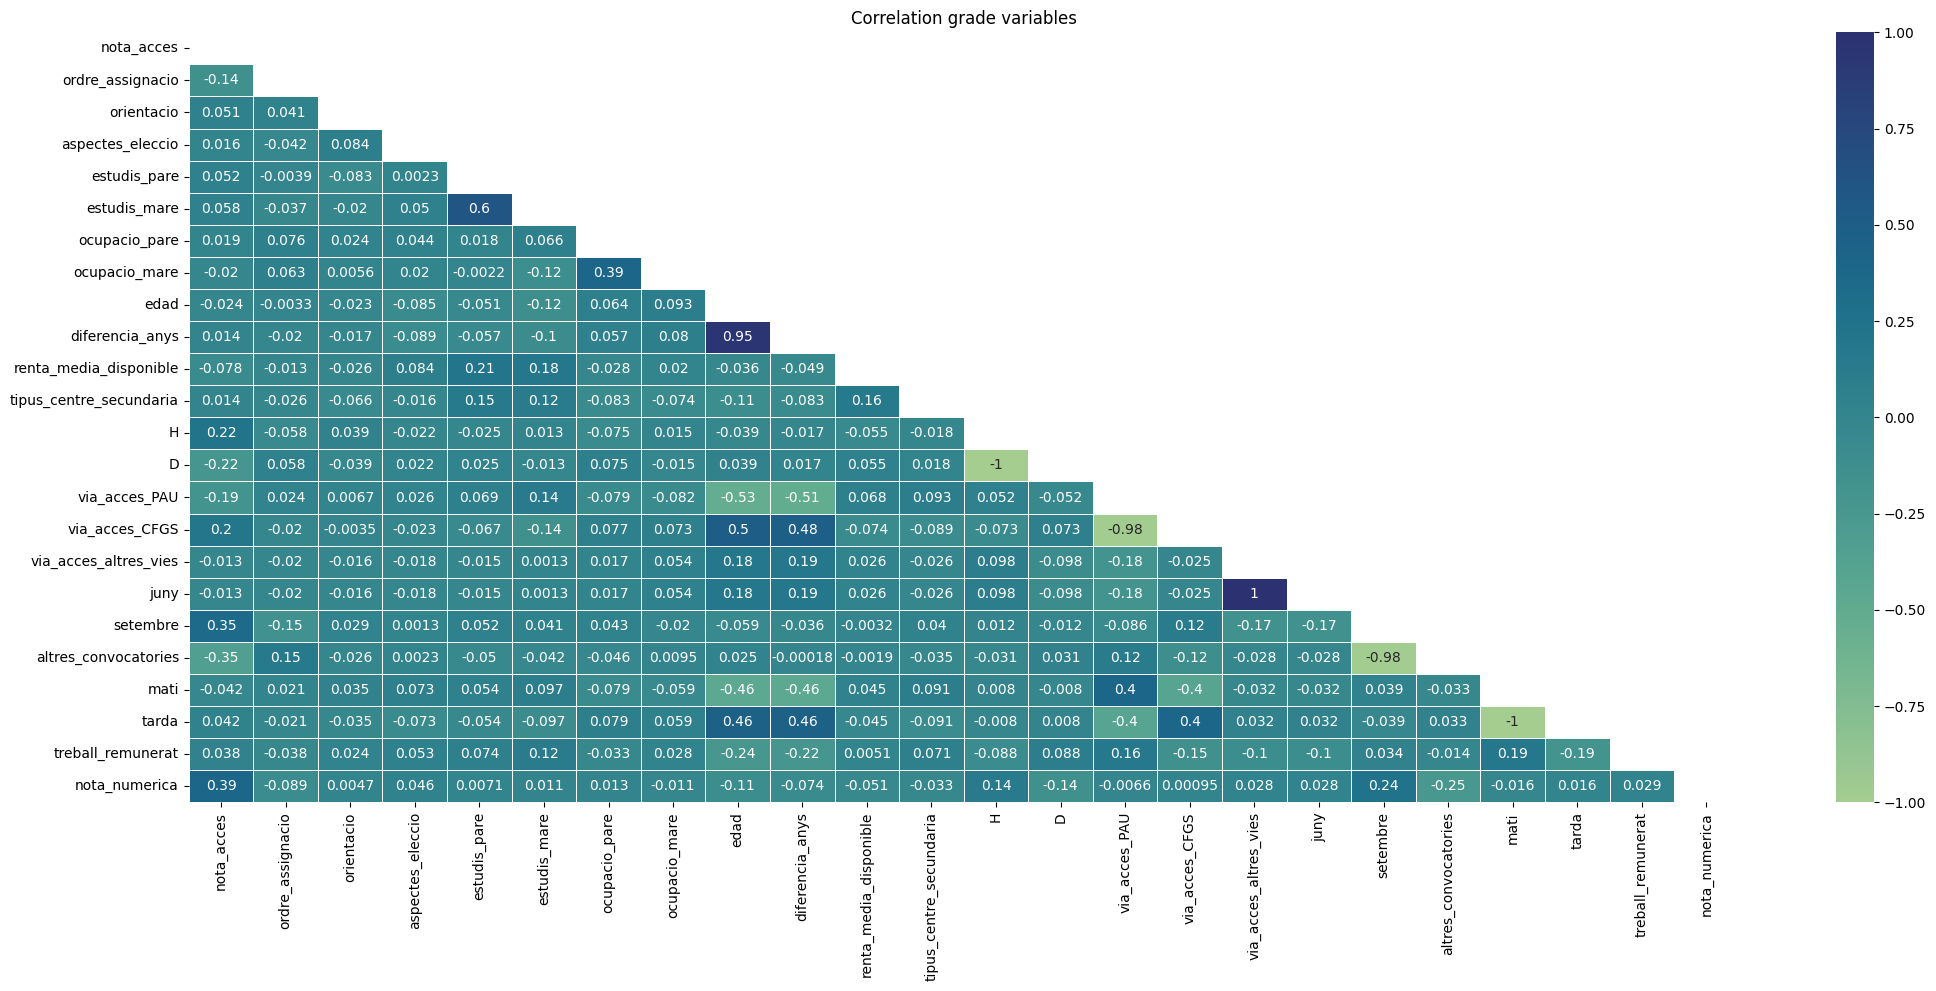

In [48]:
def heatmap_notes ():
    plt.figure(figsize=(25, 10))
    mask = np.triu(np.ones_like(numeric_variables.corr()), k=0)
    sns.heatmap(numeric_variables.corr(), annot=True, cmap='crest', linewidths=0.5, mask=mask)
    plt.title("Correlation grade variables")
    plt.show()  # Add this line to actually display the heatmap

# Call the function
heatmap_notes()

In [59]:
calculus = final_merge[final_merge['assignatura']=='Calc']


In [60]:
calculus.columns

Index(['NIA', 'nota_acces', 'ordre_assignacio', 'orientacio',
       'aspectes_eleccio', 'estudis_pare', 'estudis_mare', 'ocupacio_pare',
       'ocupacio_mare', 'edad', 'diferencia_anys', 'renta_media_disponible',
       'tipus_centre_secundaria', 'H', 'D', 'via_acces_PAU', 'via_acces_CFGS',
       'via_acces_altres_vies', 'juny', 'setembre', 'altres_convocatories',
       'mati', 'tarda', 'treball_remunerat', 'assignatura', 'nota_numerica',
       'nota_alfa'],
      dtype='object')

In [61]:
columns_to_drop = ['NIA','assignatura', 'nota_alfa']
calculus = calculus.drop(columns=columns_to_drop)

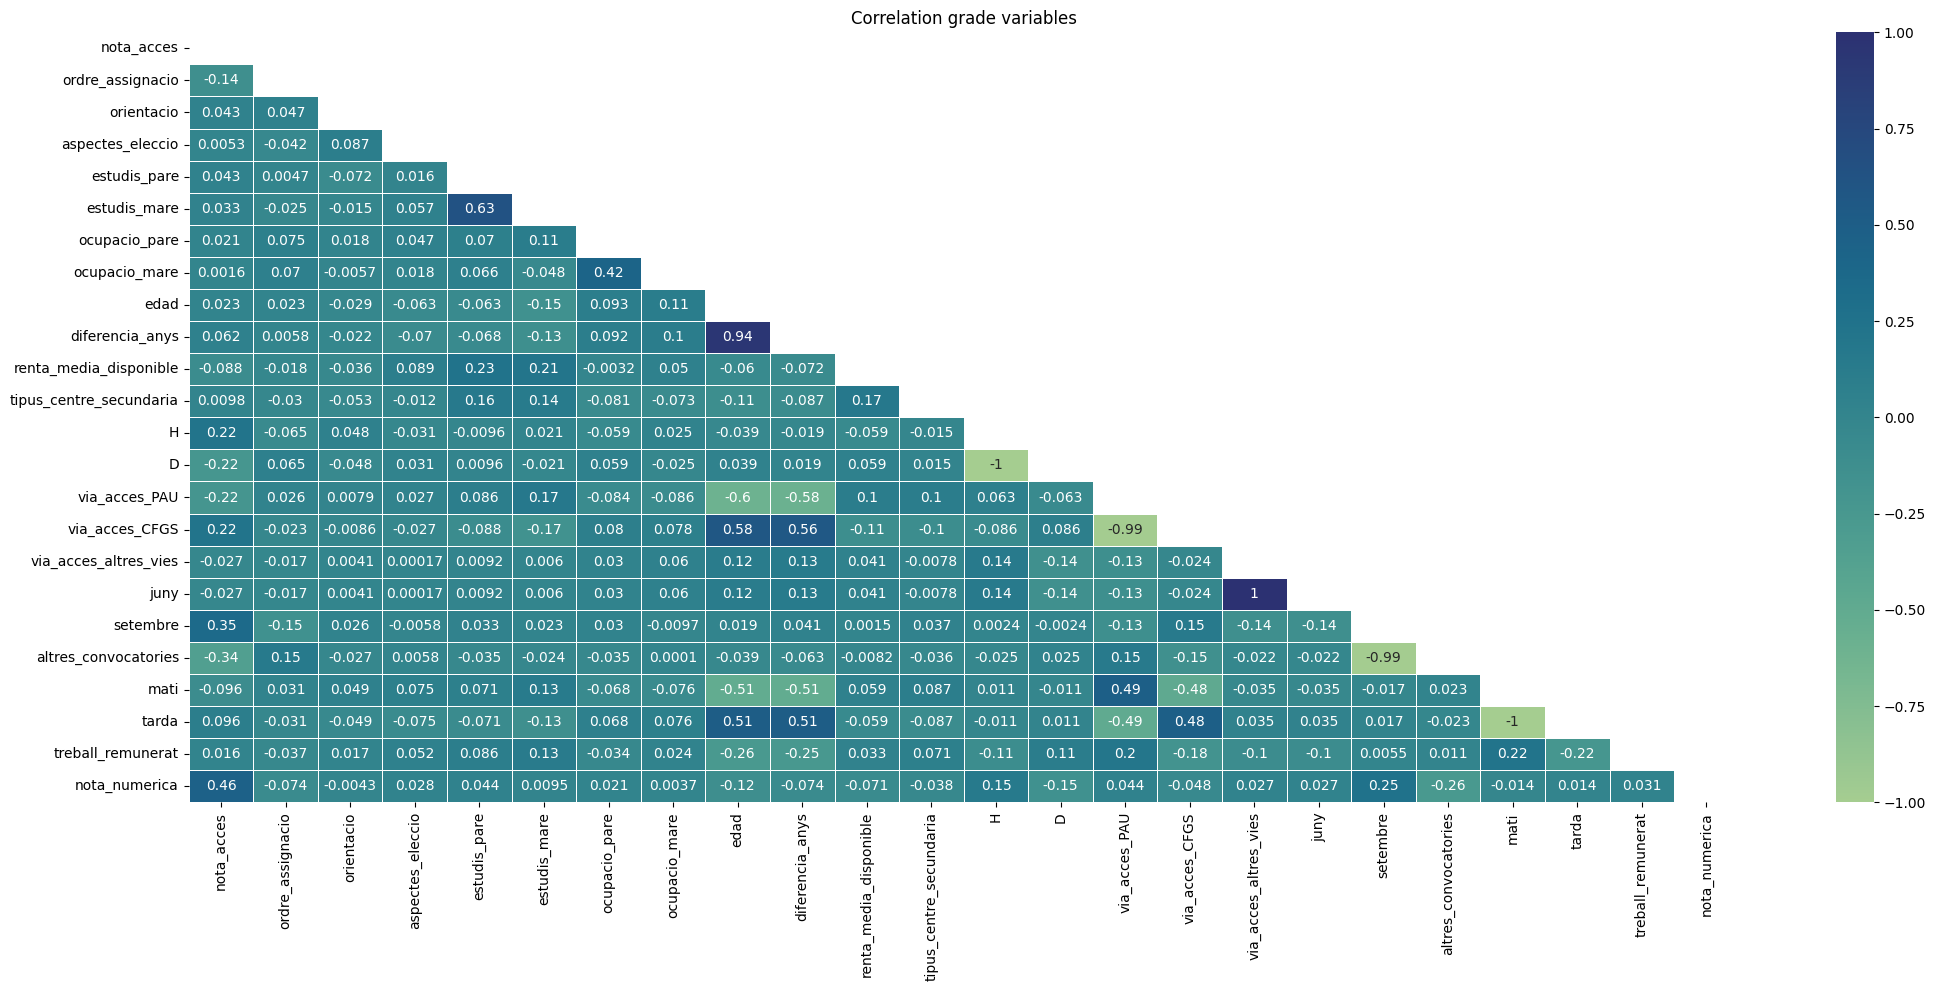

In [62]:

def heatmap_notes ():
    plt.figure(figsize=(25, 10))
    mask = np.triu(np.ones_like(calculus.corr()), k=0)
    sns.heatmap(calculus.corr(), annot=True, cmap='crest', linewidths=0.5, mask=mask)
    plt.title("Correlation grade variables")
    plt.show()  # Add this line to actually display the heatmap

# Call the function
heatmap_notes()

## Preparation for classification model

In [63]:
final_merge_students['nota_alfa'].value_counts()

nota_alfa
SS    423
AP    408
NT    359
NV     51
M      28
SB     19
NP     11
Name: count, dtype: int64

In [64]:
#We try making nota alfa PASS / NO PASS and then categories with a ranking and models performed similar.
#For this reason we opt for the one that will give us more information (From Matricula to Not presented)
new_dict_notaalfa = {
    'SS' : 1,
    'AP' : 2,
    'NT' : 3,
    'SB' : 4,
    'M' : 5,
    'NP' : 0,
    'NV' : 0,
    'CO':0}

final_merge["nota_alfa"] = final_merge["nota_alfa"].replace(new_dict_notaalfa)

In [72]:
final_merge.to_csv('../data/processed/final_merge_nota_alfa.csv',index=False)

In [69]:
final_merge.columns

Index(['NIA', 'nota_acces', 'ordre_assignacio', 'orientacio',
       'aspectes_eleccio', 'estudis_pare', 'estudis_mare', 'ocupacio_pare',
       'ocupacio_mare', 'edad', 'diferencia_anys', 'renta_media_disponible',
       'tipus_centre_secundaria', 'H', 'D', 'via_acces_PAU', 'via_acces_CFGS',
       'via_acces_altres_vies', 'juny', 'setembre', 'altres_convocatories',
       'mati', 'tarda', 'treball_remunerat', 'assignatura', 'nota_numerica',
       'nota_alfa'],
      dtype='object')

In [71]:
final_merge['nota_alfa'].value_counts()

nota_alfa
2    3192
3    3075
1    2243
0     690
4     404
5     268
Name: count, dtype: int64